<a href="https://colab.research.google.com/github/SEUNGJUNHH/2024S-Ajou-ML/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [32]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.1290162056684494
Epoch 91, Loss: 0.12043382972478867
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

In [34]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202082812786102
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.1480589509010315
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901611626148224
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [36]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [37]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [38]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [39]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [40]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


In [41]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

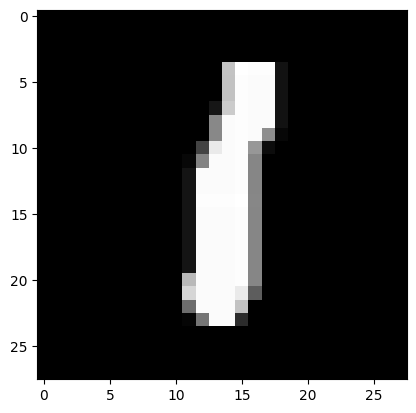

Label: 1


In [42]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
        #===================================================#
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)   #출력 layer
        #===================================================#

        )

    def forward(self, x):
        # forward 함수 구현
        #===================================================#
        #입력을 flatten해준다
        x = self.flatten(x)
        #linear_relu_stack으로 forward연산
        logits = self.linear_relu_stack(x)
        #===================================================#
        return logits # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [44]:
# hyperparameter 설정
import torch.optim as optim
FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [45]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        # 데이터 디바이스로 이동
        data_, target_ = data_.to(device), target_.to(device)
        #예측과 손실값 계산
        pred = model(data_)
        loss = loss_fn(pred, target_)


        #0으로 초기화
        optimizer.zero_grad()
        #백워드 실행
        loss.backward()
        #파라미터 업데이트
        optimizer.step()

        # 손실과 정확도 계산
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [46]:
def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            # 데이터 디바이스로 이동
            data_, target_ = data_.to(device), target_.to(device)
            #예측과 손실값 계산
            pred = model(data_)
            loss = loss_fn(pred, target_)

            # 손실과 정확도 계산
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [47]:
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [48]:
best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,FcModel ,criterion ,optimizer )

    val_acc , val_loss = test(val_loader , FcModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "/content/drive/MyDrive/checkpoints/NN_best.pth")


  0%|          | 0/10 [00:00<?, ?it/s]

epoch:0     train_loss = 1.1186 , train_acc:0.7426     val_loss = 0.4415 , val_acc:0.8824     learning rate: 0.001


 20%|██        | 2/10 [00:21<01:25, 10.72s/it]

epoch:1     train_loss = 0.3716 , train_acc:0.8943     val_loss = 0.3172 , val_acc:0.9120     learning rate: 0.001


 30%|███       | 3/10 [00:31<01:14, 10.57s/it]

epoch:2     train_loss = 0.3049 , train_acc:0.9136     val_loss = 0.2815 , val_acc:0.9176     learning rate: 0.001


 40%|████      | 4/10 [00:42<01:03, 10.52s/it]

epoch:3     train_loss = 0.2664 , train_acc:0.9243     val_loss = 0.2425 , val_acc:0.9304     learning rate: 0.001


 50%|█████     | 5/10 [00:52<00:52, 10.51s/it]

epoch:4     train_loss = 0.2356 , train_acc:0.9327     val_loss = 0.2206 , val_acc:0.9370     learning rate: 0.001


 60%|██████    | 6/10 [01:03<00:41, 10.48s/it]

epoch:5     train_loss = 0.2100 , train_acc:0.9400     val_loss = 0.1992 , val_acc:0.9442     learning rate: 0.001


 70%|███████   | 7/10 [01:13<00:31, 10.49s/it]

epoch:6     train_loss = 0.1878 , train_acc:0.9462     val_loss = 0.1812 , val_acc:0.9476     learning rate: 0.001


 80%|████████  | 8/10 [01:24<00:20, 10.47s/it]

epoch:7     train_loss = 0.1695 , train_acc:0.9517     val_loss = 0.1698 , val_acc:0.9512     learning rate: 0.001


 90%|█████████ | 9/10 [01:34<00:10, 10.45s/it]

epoch:8     train_loss = 0.1534 , train_acc:0.9562     val_loss = 0.1599 , val_acc:0.9562     learning rate: 0.001


100%|██████████| 10/10 [01:45<00:00, 10.51s/it]

epoch:9     train_loss = 0.1408 , train_acc:0.9600     val_loss = 0.1474 , val_acc:0.9566     learning rate: 0.001


# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #===============================================#
        #각 layer와 pooling을 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        #===============================================#


    def forward(self, x):

        #===============================================#
        #위에서 정의한 부분으로 조건에 맞는 forward 진행
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        #===============================================#

        return x

In [50]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [277]:
best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "/content/drive/MyDrive/checkpoints/Simple_CNN_best.pth")


 10%|█         | 1/10 [00:12<01:51, 12.44s/it]

epoch:0     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 20%|██        | 2/10 [00:25<01:40, 12.54s/it]

epoch:1     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 30%|███       | 3/10 [00:37<01:27, 12.57s/it]

epoch:2     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 40%|████      | 4/10 [00:50<01:14, 12.49s/it]

epoch:3     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 50%|█████     | 5/10 [01:02<01:02, 12.52s/it]

epoch:4     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 60%|██████    | 6/10 [01:15<00:50, 12.56s/it]

epoch:5     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 70%|███████   | 7/10 [01:27<00:37, 12.53s/it]

epoch:6     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0524 , val_acc:0.9852     learning rate: 0.001


 80%|████████  | 8/10 [01:40<00:24, 12.50s/it]

epoch:7     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


 90%|█████████ | 9/10 [01:52<00:12, 12.48s/it]

epoch:8     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


100%|██████████| 10/10 [02:04<00:00, 12.50s/it]

epoch:9     train_loss = 0.0386 , train_acc:0.9878     val_loss = 0.0523 , val_acc:0.9852     learning rate: 0.001


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [57]:
from PIL import Image
from glob import glob

In [58]:
data_path = "/content/drive/MyDrive/smoke"

In [59]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [60]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [61]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


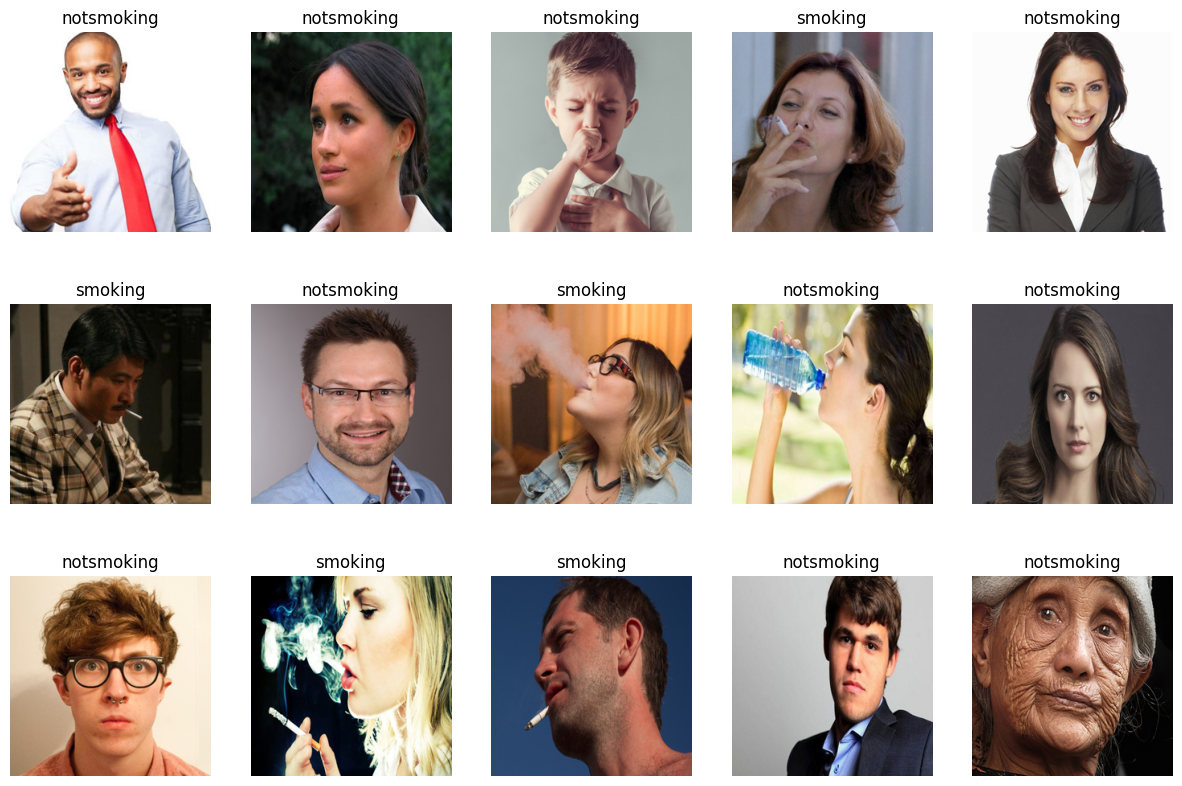

In [62]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [63]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [64]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [65]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [66]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [67]:
img, class_id = next(iter(example_dataset))

In [68]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [69]:
img, class_id = next(iter(example_loader))

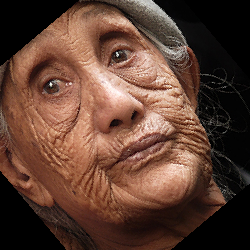

In [70]:

# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-3의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [73]:
CustomTransforms = v2.Compose([
    # 이미지를 최대 10도까지 랜덤으로 회전
    v2.RandomRotation(10),
    # 랜덤으로 이미지를 좌우 반전
    v2.RandomHorizontalFlip(),
    # 이미지의 밝기, 대비, 채도를 랜덤으로 조정
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # 랜덤으로 이미지를 자르고 크기 조정
    v2.RandomResizedCrop(32, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    # tensor로 변환
    v2.ToTensor(),
    # 이미지의 픽셀 스케일링
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [72]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()


        #===============================================#
        #기존 layer에 BatchNorm2d과 Dropout설정
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        #===============================================#

    def forward(self, x):

        #===============================================#
        #init으로 정의한 값에 맞는 forward 진행
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        #===============================================#

        return x


In [250]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        #데이터 디바이스로 보내고 optimizer초기화
        optimizer.zero_grad()
        data_, target_ = data_.to(device), target_.to(device)
        #모델 생성
        output = model(data_)
        #loss 함수 정의
        loss = loss_fn(output, target_.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        # 손실과 정확도 계산
        epoch_loss += loss.item() * data_.size(0)
        epoch_correct += (torch.round(output) == target_.unsqueeze(1)).sum().item()
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches



def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            #데이터 디바이스로 보내고
            data_, target_ = data_.to(device), target_.to(device)
            #모델생성 및 loss 함수 설정
            pred = model(data_)
            loss = loss_fn(pred, target_.unsqueeze(1).float())
            #손실과 정확도 계산
            epoch_loss += loss.item()
            epoch_correct += (torch.round(pred) == target_.unsqueeze(1)).sum().item()
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [245]:
ImpModel = ImprovedCNN().to(device)
ImpModel.cuda()

ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [251]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
#하이퍼파라미터 값 조정
optimizer = torch.optim.AdamW(ImpModel.parameters(), lr=0.0001, weight_decay=0.0001)
cosine_lr_scheduler = CosineAnnealingLR(optimizer, T_max=20)
#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [255]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   ImpModel ,
                                   criterion ,
                                   optimizer ,
                                   cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , ImpModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "/content/drive/MyDrive/checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1


    if counter >= patience:
        test_acc , val_loss = test(test_loader , ImpModel , criterion)
        print("Early stop !")
        print(test_acc)
        break

  1%|          | 1/100 [00:10<17:00, 10.31s/it]

epoch:0     train_loss = 3.9372 , train_acc:0.9064     val_loss = 0.4249 , val_acc:0.8000     learning rate: 1.464466094067263e-05


  2%|▏         | 2/100 [00:20<16:52, 10.33s/it]

epoch:1     train_loss = 3.9766 , train_acc:0.9036     val_loss = 0.4831 , val_acc:0.7722     learning rate: 9.549150281252635e-06


  3%|▎         | 3/100 [00:30<16:38, 10.29s/it]

epoch:2     train_loss = 3.0225 , train_acc:0.9413     val_loss = 0.4634 , val_acc:0.7778     learning rate: 5.4496737905816115e-06


  4%|▍         | 4/100 [00:41<16:24, 10.25s/it]

epoch:3     train_loss = 3.6834 , train_acc:0.9078     val_loss = 0.4478 , val_acc:0.8111     learning rate: 2.4471741852423237e-06


  5%|▌         | 5/100 [00:51<16:12, 10.23s/it]

epoch:4     train_loss = 3.4480 , train_acc:0.9092     val_loss = 0.4529 , val_acc:0.8056     learning rate: 6.155829702431171e-07


  6%|▌         | 6/100 [01:01<15:59, 10.21s/it]

epoch:5     train_loss = 3.1284 , train_acc:0.9274     val_loss = 0.4897 , val_acc:0.7667     learning rate: 0.0


  7%|▋         | 7/100 [01:11<15:51, 10.24s/it]

epoch:6     train_loss = 3.0999 , train_acc:0.9358     val_loss = 0.4942 , val_acc:0.7889     learning rate: 6.155829702431115e-07


  8%|▊         | 8/100 [01:22<15:46, 10.29s/it]

epoch:7     train_loss = 3.4191 , train_acc:0.9162     val_loss = 0.4521 , val_acc:0.7889     learning rate: 2.4471741852423127e-06


  9%|▉         | 9/100 [01:32<15:42, 10.35s/it]

epoch:8     train_loss = 3.4535 , train_acc:0.9162     val_loss = 0.4551 , val_acc:0.7833     learning rate: 5.4496737905816055e-06


 10%|█         | 10/100 [01:42<15:30, 10.34s/it]

epoch:9     train_loss = 3.2408 , train_acc:0.9204     val_loss = 0.4749 , val_acc:0.7722     learning rate: 9.549150281252623e-06
epoch:10     train_loss = 3.4662 , train_acc:0.9092     val_loss = 0.4825 , val_acc:0.8111     learning rate: 1.4644660940672617e-05


 10%|█         | 10/100 [01:55<17:22, 11.59s/it]

Early stop !
0.7767857142857143


In [153]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [155]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [156]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [157]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [158]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [159]:
nn.Linear(10,10).requires_grad = False # gradiant 끄기
# nn.Linear(10,10).requires_grad = True # gradiant 켜기

In [160]:
import torch.nn as nn
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model):
        super(MyVGG16, self).__init__()
        #이전모델 features 불러오기
        self.features = pretrained_model.features
        # VGG16의 CNN 레이어들을 동결
        for param in self.features.parameters():
            param.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x


In [161]:
myvgg16 = MyVGG16(vgg16).to(device)

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [162]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
#freeze된 layer 풀기
for param in myvgg16.features.parameters():
        param.requires_grad = True
#하이퍼 파라미터 값 조정
optimizer = optim.Adam(myvgg16.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [163]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        #데이터 device로 전환
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        pred = model(data_)
        #손실계산
        loss = loss_fn(pred, target_.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        # 현재 배치의 손실을 배치 크기로 가중치를 두어 누적
        epoch_loss += loss.item() * data_.size(0)
        # 예측값이 0.5 초과하면 정답, 맞춘 개수를 누적
        epoch_correct += ((pred > 0.5).float() == target_.unsqueeze(1)).sum().item()
        #===================================================#

    train_acc = epoch_correct/size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data_, target_ = data_.to(device), target_.to(device)
            pred = model(data_)
            loss = loss_fn(pred, target_.float().unsqueeze(1))
            epoch_loss += loss.item() * data_.size(0)
            epoch_correct += ((pred > 0.5).float() == target_.unsqueeze(1)).sum().item()
            #========================================#

    test_acc = epoch_correct/size

    return test_acc  , epoch_loss / num_baches

In [164]:
myvgg16.cuda()

MyVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [165]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   myvgg16 ,
                                   criterion ,
                                   optimizer ,
                                   lr_scheduler)

    val_acc , val_loss = test(val_loader , myvgg16 , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict() , "checkpoints/vgg_16_best.pth")
    else:
        counter+=1

    if counter >= patience:
        test_acc , val_loss = test(test_loader , myvgg16 , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 9.9335 , train_acc:0.6564     val_loss = 7.6275 , val_acc:0.7667     learning rate: 9.890738003669029e-05


  1%|          | 1/100 [00:10<17:58, 10.89s/it]

epoch:1     train_loss = 8.4361 , train_acc:0.7668     val_loss = 6.7879 , val_acc:0.8000     learning rate: 9.567727288213005e-05


  3%|▎         | 3/100 [00:32<17:36, 10.90s/it]

epoch:2     train_loss = 7.5351 , train_acc:0.7919     val_loss = 7.6167 , val_acc:0.7778     learning rate: 9.045084971874738e-05


  4%|▍         | 4/100 [00:43<17:11, 10.75s/it]

epoch:3     train_loss = 6.0755 , train_acc:0.8324     val_loss = 7.6296 , val_acc:0.7778     learning rate: 8.345653031794292e-05


  5%|▌         | 5/100 [00:53<16:49, 10.62s/it]

epoch:4     train_loss = 4.7115 , train_acc:0.8799     val_loss = 7.3955 , val_acc:0.7944     learning rate: 7.500000000000001e-05


  6%|▌         | 6/100 [01:04<16:38, 10.62s/it]

epoch:5     train_loss = 4.5348 , train_acc:0.8827     val_loss = 7.6840 , val_acc:0.7556     learning rate: 6.545084971874738e-05


  7%|▋         | 7/100 [01:14<16:29, 10.64s/it]

epoch:6     train_loss = 3.6334 , train_acc:0.9148     val_loss = 7.6652 , val_acc:0.7833     learning rate: 5.522642316338269e-05


  8%|▊         | 8/100 [01:25<16:16, 10.61s/it]

epoch:7     train_loss = 2.3736 , train_acc:0.9330     val_loss = 8.4687 , val_acc:0.8333     learning rate: 4.4773576836617344e-05


  9%|▉         | 9/100 [01:35<15:59, 10.54s/it]

epoch:8     train_loss = 1.4171 , train_acc:0.9721     val_loss = 12.2303 , val_acc:0.7833     learning rate: 3.454915028125264e-05


 10%|█         | 10/100 [01:46<15:50, 10.56s/it]

epoch:9     train_loss = 2.0704 , train_acc:0.9525     val_loss = 10.6668 , val_acc:0.7778     learning rate: 2.5000000000000018e-05


 11%|█         | 11/100 [01:57<15:42, 10.59s/it]

epoch:10     train_loss = 0.8715 , train_acc:0.9860     val_loss = 9.8091 , val_acc:0.8167     learning rate: 1.654346968205711e-05
epoch:11     train_loss = 0.8216 , train_acc:0.9804     val_loss = 11.6384 , val_acc:0.7889     learning rate: 9.549150281252635e-06


 11%|█         | 11/100 [02:10<17:33, 11.84s/it]

Early stop !
0.8169642857142857


# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [216]:
model_state_dict = torch.load("/content/drive/MyDrive/checkpoints/Improved_CNN_best.pth")
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(model_state_dict)

<All keys matched successfully>

In [217]:
model_state_dict = torch.load("/content/checkpoints/vgg_16_best.pth")
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
myvgg16 = MyVGG16(vgg16).to(device)
myvgg16.load_state_dict(model_state_dict)

<All keys matched successfully>

In [218]:
#=================================#
#테스트 결과 불러오기
vgg_test_acc , val_loss = test(test_loader , myvgg16 , criterion)
imp_test_acc, imp_test_loss = test(test_loader, ImpModel, criterion)
#=================================#
print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")

ImpCNN 0.7589285714285714
MyVgg16 0.8214285714285714
